# `rioxarray`

In this lesson we will introduce [`rioxarray`](https://corteva.github.io/rioxarray/stable/), a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 

The name `rioxarray` stands for *raster input/output + xarray*. 

## About the data
The raster files we will use today come from the [US National Agriculture Imagery Program (NAIP)](https://naip-usdaonline.hub.arcgis.com). 
NAIP images are are high-resolution aerial images with four spectral bands: red (R), green (G), blue (B) and near-infrared (NIR). 
The raster's we'll use today are from 2020.

The data used in this lesson was pre-processing from a complete NAIP scene to separate the RGB bands from the NIR band and reduce the spatial extent. 
The data was accessed through [Microsoft's Planetary Computer NAIP data repository](https://planetarycomputer.microsoft.com/dataset/naip#overview).

## Import a TIF file

Let's start by loading the libraries we will use: 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr

There are [multiple ways of opening a TIF file using `xarray` or `rioxarray`](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html). 
Using the `rioxarray.open_rasterio()` function to open the TIF file is a simple way to import the raster file as an `xarray.DataArray` and make sure all our geospatial data gets loaded correctly:

In [2]:
# Import NIR TIF file
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'rioxarray_lesson_data')

fp = os.path.join(root,
                 'NAIP_SB_nir.tif')

nir = rioxr.open_rasterio(fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)> Size: 8MB
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
print('Shape: ', nir.shape)
print('Data type: ', nir.shape)

Shape:  (1, 3208, 2419)
Data type:  (1, 3208, 2419)


`uint8` = one of the smallest number datatypes for python = unsigned integers with 8 bits. It is used to represent numbers from 0 to 254

we can access the underlying `numpy.array` holding the values of the variable

In [4]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

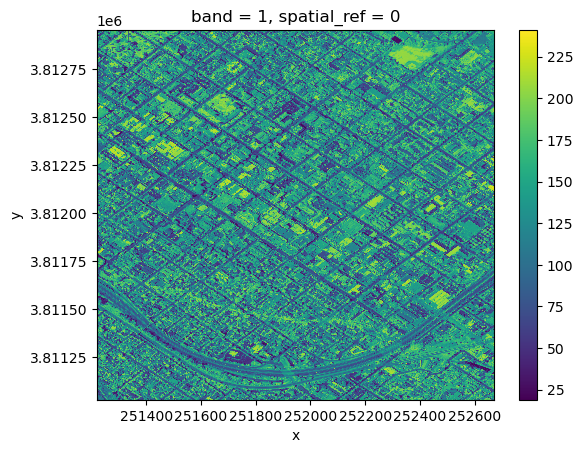

In [5]:
nir.plot()

## drop a dimension

notice that our raster has an unnecessary extra dimension: band

In [6]:
# print dimension sizes
# dict gets rid of the `frozen`
print('Sizes of dimensions: ', dict(nir.sizes))

Sizes of dimensions:  {'band': 1, 'y': 3208, 'x': 2419}


In [7]:
#vs 
nir.sizes

Frozen({'band': 1, 'y': 3208, 'x': 2419})

lets squeez the band dimension by:

1. `squeeze()` method, with no parameters it gets rid of all dimensions of length 1
2. drop the coordinates associated with the dimension using drop_vars()

In [8]:
# original dimensions and coordinates
print(nir.dims, nir.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [9]:
# remove length 1 dimension (band)
nir = nir.squeeze()
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


In [10]:
# its still holding the band dimension's info even though we removed the dimension itself
# so we remove the information
nir = nir.drop_vars('band')
print(nir.dims, nir.coords)

('y', 'x') Coordinates:
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0


## `rio` accessor

use the `.rio` accessor for an `xarray.DataArray` to access its raster properties:

In [11]:
print('number of bands: ', nir.rio.count)
print('Height: ', nir.rio.height)
print('width: ', nir.rio.width)
print('Spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS', nir.rio.crs)

number of bands:  1
Height:  3208
width:  2419
Spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS EPSG:26911


## multi-band raster

lets import the RGB raster:

In [12]:
# import RGB raster
fp = os.path.join(root, 'NAIP_SB_rgb.tif')
rgb = rioxr.open_rasterio(fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)> Size: 23MB
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 19kB 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 26kB 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

since this raster has three bands, we can plot it as an image using the `.plot.imshow()` method which will interpret the three bands of the object as RGB bands

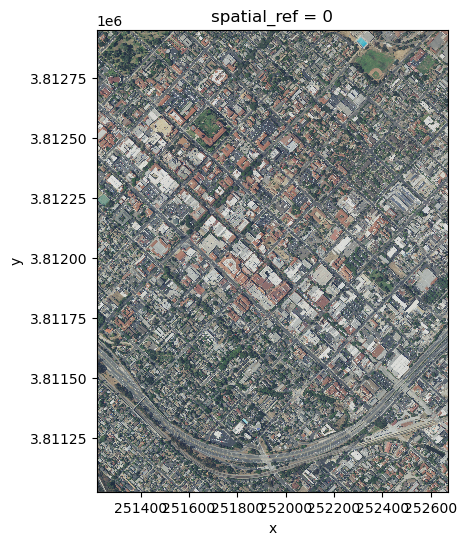

In [13]:
# plot three bands as RGB image

rgb_aspect_ratio = rgb.rio.width / rgb.rio.height # rasters aspect ratio
rgb.plot.imshow(size = 6, # plot's height in inches
                aspect = rgb_aspect_ratio) # ratio if width/height

## clip a raster

our  area of interest (AOI) for this lesson is a smaller region including a few blocks around NCEAS. this area is already outlined in a GeoJSON file:

In [14]:
fp = os.path.join(root, 'SB_aoi.geojson')

aoi = gpd.read_file(fp)

Remember: we need to match the crs every time we work with geospatial data

In [15]:
# examine CRS
print('apo CRS ', aoi.crs)
print('nir CRS ', nir.rio.crs)
print('rgb crs ', rgb.rio.crs)

apo CRS  EPSG:4326
nir CRS  EPSG:26911
rgb crs  EPSG:26911


In [16]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
assert aoi.crs == rgb.rio.crs

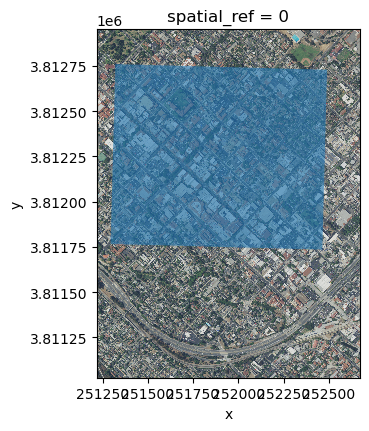

In [17]:
# plot rbg raster with aoi overlay
fig, ax = plt.subplots(figsize = (6, 6*rgb_aspect_ratio)) # directy set size
rgb.plot.imshow(ax = ax)
aoi.plot(ax = ax, alpha = 0.6)
plt.show()

to clip the raster we use the `rio.clip_box()` method:

In [18]:
# clip rasters to AOI
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Original shape:  (3208, 2419)
Clipped shape:  (1710, 1995)


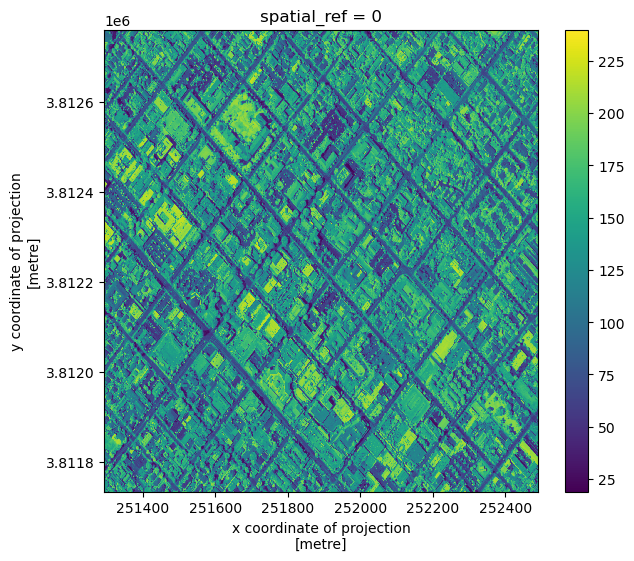

In [19]:
# Examine clipped data 
print('Original shape: ', nir.shape)
print('Clipped shape: ', nir_small.shape)


# plot with correct size
ratio = rgb_small.rio.width / rgb_small.rio.height 
nir_small.plot.imshow(size = 6, 
                      aspect = ratio)

## raster algebra

in our case we are interested in computing the normalized difference vegetation index (NDVI).
NDVI is an index commonly used to check if an area has live green vegetation or not.

- NDVI calculation ranges from -1 go 1
- negative values = water, impervious surfaces, rocks, snow, clouds
- positive values = bare soil (0.1-0.2), plants (0.2-1)

formulat for ndvi is

$NDVI = \frac{NIIR - RED}{NIR + RED}$

In [20]:
# select the red band (by selecting dimensions by name and coordinate by label)
red = rgb_small.sel(band = 1)
red

<xarray.DataArray (y: 1710, x: 1995)> Size: 3MB
[3411450 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 2.513e+05 2.513e+05 ... 2.525e+05 2.525e+05
  * y            (y) float64 14kB 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

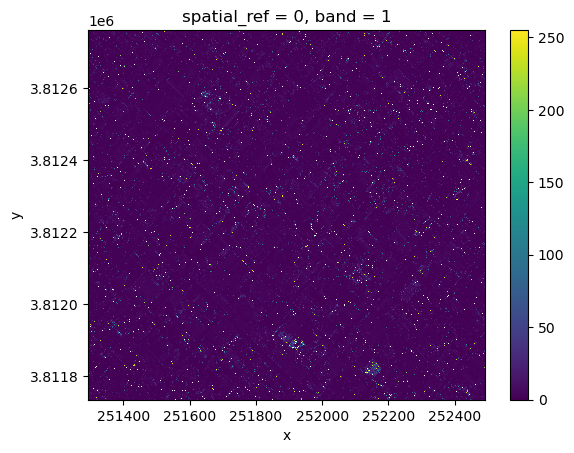

In [21]:
ndvi = (nir - red)/(nir + red)
ndvi.plot()

## data type issues
the rasters had data type `uint8`, a very small data type holding only integers from 0 to 255. In particular, when you do calculations with `uint8` they dont return what you would expect when working with integers

because the highest possible `uint8` value is 254, u can easily get overflow issues

## update date types

to be able to perform calculations sucessfully, we will need to update the data type of our rasters into `int16`

In [22]:
# update data type to int16 to perform NDVI calculation
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')

print(red16.dtype)
print(nir16.dtype)

int16
int16


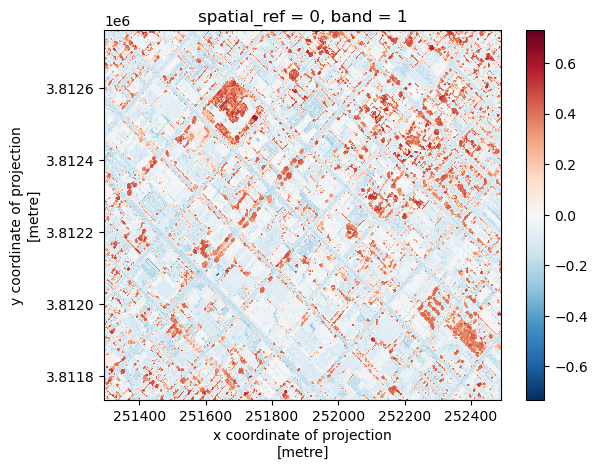

In [24]:
# calculate ndvi
ndvi = (nir16 - red16)/(nir16 + red16)
ndvi.plot()